<a href="https://colab.research.google.com/github/jsong55/Machine_Learning/blob/master/Depth_estimation_EfficientNetB0_trainable_params_no_aug_label02468_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import random
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential, layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import datetime
import tensorflow_hub as hub
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
from TF_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, view_random_image

--2022-11-23 20:44:46--  https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10747 (10K) [text/plain]
Saving to: ‘TF_functions.py’

TF_functions.py     100%[===================>]  10.50K  --.-KB/s    in 0s      

2022-11-23 20:44:46 (114 MB/s) - ‘TF_functions.py’ saved [10747/10747]



image shape: (150, 150, 3)


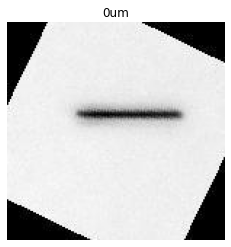

In [3]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/python_torturial/NW_depth_6MWs_02468.zip","r")
zip_ref.extractall()
zip_ref.close()

# Setup the train and test directories
train_dir = "NW_depth_6MWs_02468/train/"
test_dir = "NW_depth_6MWs_02468/test/"

# visualize
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

img = view_random_image(target_dir=train_dir,
              target_class=random.choice(class_names))

In [4]:
IMAGE_SIZE = (150,150)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                        image_size=IMAGE_SIZE,
                                        label_mode="categorical",
                                        batch_size=32,
                                        shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                  image_size=IMAGE_SIZE,
                                  label_mode="categorical",
                                  batch_size=32)

Found 3127 files belonging to 5 classes.
Found 800 files belonging to 5 classes.


In [5]:
# create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    #preprocessing.RandomFlip("horizontal"),
    #preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
#    preprocessing.Rescaling(1./255) need for resnet but not for efficientnet
],name="data_augmentation")

NW_depth_6MWs_02468/train/4um
NW_depth_6MWs_02468/train/4um/data-611.jpeg


Text(0.5, 1.0, 'Augmented random image from: 4um')

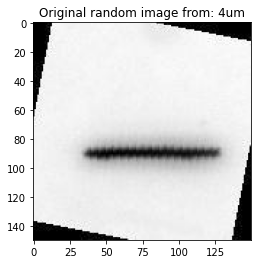

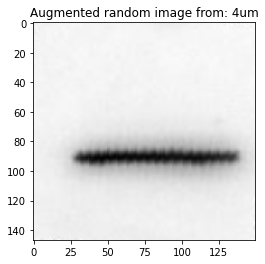

In [9]:
# view a random image and compare it to its augmented version
target_class = random.choice(train_data.class_names)
target_dir = "NW_depth_6MWs_02468/train/" + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from: {target_class}")

# Let's plot augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from: {target_class}")

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Check the layers in our base model
#for layer_number, layer in enumerate(base_model.layers):
#  print(layer_number, layer.name)

# The model contains a noramlization and rescaling layer

# 2. Free the base model (the underlying pre-trained patterns aren't updated during training)
base_model.trainable = True

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(150,150,3),name="input_layer")
# Add in data augmentation sequential model as a layer
# x = data_augmentation(inputs)

# 4. If using a model like ResNet50V2, you will need to noramlize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(5,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
        optimizer = Adam(learning_rate=0.001),
        metrics=["accuracy"])

# 10. Fit the model and save the history
history_0 = model_0.fit(train_data,
                  epochs=30,
                  steps_per_epoch=len(train_data),
                  validation_data=test_data,
                  validation_steps=len(test_data),
                  callbacks=[create_tensorboard_callback(dir_name="EfficientNetB0",
                                      experiment_name="EfficientNetB0_test1")])

Saving TensorBoard log files to: EfficientNetB0/EfficientNetB0_test1/20221123-204554
Epoch 1/30
98/98 [==============================] - 31s 127ms/step - loss: 1.1300 - accuracy: 0.5069 - val_loss: 1.5468 - val_accuracy: 0.4100
Epoch 2/30
98/98 [==============================] - 11s 108ms/step - loss: 0.6664 - accuracy: 0.7157 - val_loss: 1.3292 - val_accuracy: 0.4863
Epoch 3/30
98/98 [==============================] - 11s 107ms/step - loss: 0.5043 - accuracy: 0.7867 - val_loss: 2.1924 - val_accuracy: 0.4712
Epoch 4/30
98/98 [==============================] - 11s 108ms/step - loss: 0.3604 - accuracy: 0.8567 - val_loss: 1.0276 - val_accuracy: 0.6575
Epoch 5/30
98/98 [==============================] - 11s 107ms/step - loss: 0.3440 - accuracy: 0.8756 - val_loss: 1.4666 - val_accuracy: 0.5800
Epoch 6/30
98/98 [==============================] - 10s 105ms/step - loss: 0.2590 - accuracy: 0.9021 - val_loss: 1.2043 - val_accuracy: 0.6150
Epoch 7/30
98/98 [==============================] - 10s 1

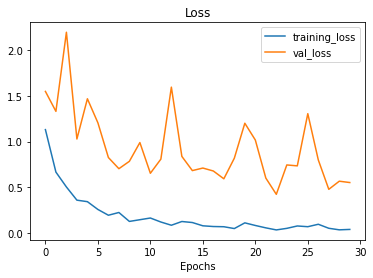

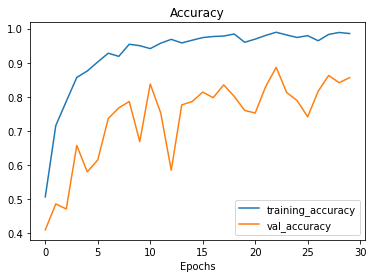

In [12]:
plot_loss_curves(history_0)

In [9]:
# save model
model_0.save('efficientnetB0_nw_pitch_angle.h5')
print('Model Saved!')
# load model
# savedModel=load_model('gfgModel.h5')
# savedModel.summary()

Model Saved!


In [10]:
model_0.evaluate(test_data)

94/94 [==============================] - 2s 16ms/step - loss: 0.0011 - accuracy: 0.9993


[0.0011001199018210173, 0.9993297457695007]